In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle
import os
from utils import *

from IPython.display import display, clear_output
from rlutils import ReplayBuffer, HistoryWriter
from sac import SoftActorCritic
from envs import OptimizationEnv

In [2]:
channel = 0
buffer_size = 10000

path_models = 'models/'
path_buffer = 'data/'

In [3]:
env = OptimizationEnv(reset_params=False)
state, info = env.reset(new_params=False)
action = env.action_space.sample()

/Users/felix/.pyenv/versions/3.8.6/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [4]:
buffer = ReplayBuffer(buffer_size=buffer_size, input_shape=(env.observation_space.shape[0],), n_actions=env.action_space.shape[0], memmap_loc=path_buffer)

writer = HistoryWriter()

agent = SoftActorCritic(env, lr=1e-2, gamma=.99, batch_size=64, learning_starts=64, gradient_steps=8, buffer_size=buffer_size, buffer=buffer, 
                        device='cpu')
agent.save(path_models)

In [5]:
mtime = os.path.getmtime(path_buffer + 'state_memory_channel_{}.npy'.format(channel))
print(mtime)

1675516624.754843


In [6]:
# we can access the buffer with read rights
steps_counter = 0
while True:
    clear_output(wait=True)
    
    # train only if buffer changed
    current_mtime = os.path.getmtime(path_buffer + 'state_memory_channel_{}.npy'.format(channel))
    if True: #current_mtime > mtime:
        print('buffer total: {}'.format(agent.buffer.buffer_total))
        if agent.buffer.buffer_total > agent.learning_starts and agent.buffer.buffer_total > agent.batch_size:
            print('train ...')
            for j in range(agent.gradient_steps):
                update_target_value = True if agent.buffer.buffer_total % agent.target_update_interval == 0 else False
                agent._learn_step(update_target_value=update_target_value, writer=writer)
                        
            steps_counter += agent.gradient_steps
            agent.save(path_models)
    mtime = current_mtime
    greedy_action, greedy_likelihood = agent.predict(np.array([0,0]), greedy=True)
    print('greedy action is: {}, with likelihood: {}'.format(greedy_action, np.exp(greedy_likelihood)))
    print('steps trained: {}, buffer last modified: {}'.format(steps_counter, mtime))    
    time.sleep(.5)

buffer total: [167]
train ...


KeyboardInterrupt: 

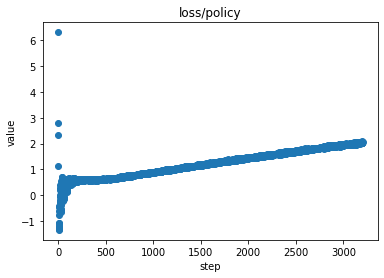

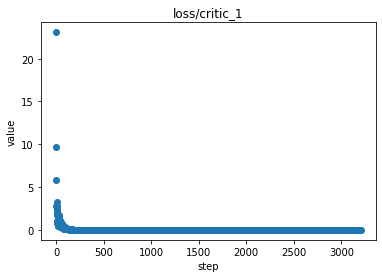

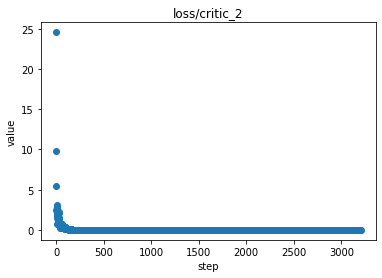

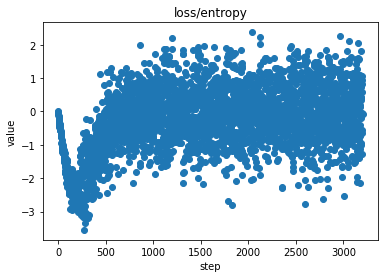

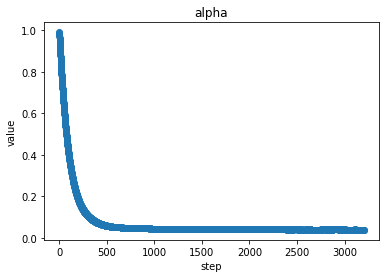

In [7]:
for key in writer.history.keys():
    writer.plot(key)

In [8]:
for p in agent.policy.parameters():
    print(p.shape)
    if len(p.shape) == 0:
        print(p.item())
    elif len(p.shape) == 1:
        print(p[0].item())
    elif len(p.shape) == 2:
        print(p[0,0].item())

torch.Size([256, 2])
-0.002489911625161767
torch.Size([256])
-0.04789845645427704
torch.Size([256, 256])
2.6741561534871643e-38
torch.Size([256])
-0.005088721867650747
torch.Size([2, 256])
-0.01956433430314064
torch.Size([2])
0.5630691647529602
torch.Size([2, 256])
0.04247087985277176
torch.Size([2])
-0.5445024967193604
